# Measuring accuracy of XGBoost models 
(using stratified 5-fold cross validation, and a model with 10 features)

## Plain English summary

We have decided to simplify our model by using 10 independent features to predict which patients receive thrombolysis. This gives a good balance of performance (in terms of ROC AUC, achieving over 99% of what can be obtained with all of the 84 features) and model complexity. 

There are many other ways in which to report model performance - in this notebook we will report on a range of these. The overall model accuracy is 84.7%, so between 8 and 9 out of 10 instances will have a correct prediction. The model is also well calibrated (for example, all of the patients that a model predicts 40% probability for, 40% of them did receive it).

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Receive thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will receive thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims

* Measure a range of accuracy scores (e.g. accuracy, sensitivity, specificity, F1, etc).
* Plot Receiver Operator Characteristic Curve and measure AUC.
* Identify cross-over point of sensitivity and specificity.
* Compare predicted and observed thrombolysis use at each hospital.
* Examine feature importances
* Check model calibration (reliability)
* Examine learning curves
* Save individual patient predictions.

## Observations

* Overall accuracy = 85.0%
* Using nominal threshold (50% probability), specificity (89.4%) is greater than sensitivity (74.3%)
* The model can achieve 83.9% sensitivity and specificity simultaneously
* ROC AUC = 0.918
* The model explains 97.7% of the variation of the observed thrombolysis use at each hospital.
* The top 5 features are: 1) stroke type, 2) use of AF anticoagulants, 3) onset during sleep, 4) onset time type, 5) stroke severity.
* The model is well calibrated
* We have sufficient volume of data to train a model

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
import pickle
from sklearn import metrics

import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '02'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty lists
train_data_kfold, test_data_kfold = [], []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

# For each k-fold split
for k in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(k))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data_kfold.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(k))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data_kfold.append(test)

## Functions 

### Calculate accuracy measures

In [7]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Fit XGBoost model

Fit XGBoost model for each k-fold training/test split, and get feature importance values (a value per feature, per model from each k-fold split).

Save models.

In [8]:
# Fit models (True), or load models (False)
fit_models = True

# Set up lists to store k-fold fits
model_kfold = []
feature_importance_kfold = []
y_pred_proba_kfold = []
y_pred_class_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []
accuracy_kfold = []

# Loop through k folds
for k in range(5):
    
    # Get X and y
    X_train = train_data_kfold[k].drop('Thrombolysis', axis=1)
    X_test = test_data_kfold[k].drop('Thrombolysis', axis=1)
    y_train = train_data_kfold[k]['Thrombolysis']
    y_test = test_data_kfold[k]['Thrombolysis']
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    

    # Store processed X and y
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Fit model
    if fit_models:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
        model.fit(X_train, y_train)
        model_kfold.append(model)

        # Save using pickle
        filename = (f'./saved_models/'
                    f'{notebook}_{model_text}_{k}.p')
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
    else:
        # Load models
        filename = (f'./saved_models/'
                    f'{notebook}_{model_text}_{k}.p')
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_kfold.append(model)        
    
    # Get and store predicted probability
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_proba_kfold.append(y_pred_proba)
    
    # Get and store predicted class
    y_pred_class = y_pred_proba >= 0.5
    y_pred_class = np.array(y_pred_class) * 1.0
    y_pred_class_kfold.append(y_pred_class)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)
        
    # Print accuracy
    accuracy_kfold.append(np.mean(y_pred_class == y_test))
    print (
        f'Run {k}, accuracy: {accuracy_kfold[k]:0.3f}')

Run 0, accuracy: 0.848
Run 1, accuracy: 0.853
Run 2, accuracy: 0.845
Run 3, accuracy: 0.854
Run 4, accuracy: 0.848


## Results 

### Accuracy measures 

In [9]:
# Set up list for results
results_kfold = []

# Loop through k fold predictions and get accuracy measures
for k in range(5):
    results = calculate_accuracy(y_test_kfold[k], y_pred_class_kfold[k])
    results_kfold.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(results_kfold).T

In [10]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.295963,0.295737,0.295867,0.295529,0.295472
observed_negative_rate,0.704037,0.704263,0.704133,0.704471,0.704528
predicted_positive_rate,0.293879,0.293035,0.296824,0.292995,0.294008
predicted_negative_rate,0.706121,0.706965,0.703176,0.707005,0.705992
accuracy,0.848246,0.852582,0.845197,0.853981,0.847843
precision,0.745354,0.753075,0.737621,0.755141,0.743727
recall,0.740107,0.746192,0.740008,0.748666,0.740042
f1,0.742721,0.749617,0.738812,0.751890,0.741880
sensitivity,0.740107,0.746192,0.740008,0.748666,0.740042
specificity,0.893706,0.897258,0.889395,0.898161,0.893054


In [11]:
accuracy_results.T.describe().T

,count,mean,std,min,25%,50%,75%,max
observed_positive_rate,5.0,0.295714,0.000211,0.295472,0.295529,0.295737,0.295867,0.295963
observed_negative_rate,5.0,0.704286,0.000211,0.704037,0.704133,0.704263,0.704471,0.704528
predicted_positive_rate,5.0,0.294148,0.001567,0.292995,0.293035,0.293879,0.294008,0.296824
predicted_negative_rate,5.0,0.705852,0.001567,0.703176,0.705992,0.706121,0.706965,0.707005
accuracy,5.0,0.849570,0.003619,0.845197,0.847843,0.848246,0.852582,0.853981
precision,5.0,0.746984,0.007151,0.737621,0.743727,0.745354,0.753075,0.755141
recall,5.0,0.743003,0.004134,0.740008,0.740042,0.740107,0.746192,0.748666
f1,5.0,0.744984,0.005523,0.738812,0.741880,0.742721,0.749617,0.751890
sensitivity,5.0,0.743003,0.004134,0.740008,0.740042,0.740107,0.746192,0.748666
specificity,5.0,0.894315,0.003522,0.889395,0.893054,0.893706,0.897258,0.898161


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [12]:
# Set up lists for results
fpr_kfold = [] # false positive rate
tpr_kfold = [] # true positive rate
thresholds_kfold = [] # threshold applied
auc_kfold = [] # area under curve

# Loop through k fold predictions and get ROC results 
for k in range(5):
    fpr, tpr, thresholds = roc_curve(y_test_kfold[k], y_pred_proba_kfold[k])
    roc_auc = auc(fpr, tpr)
    fpr_kfold.append(fpr)
    tpr_kfold.append(tpr)
    thresholds_kfold.append(thresholds)
    auc_kfold.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(auc_kfold)
sd_auc = np.std(auc_kfold)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.9180
SD AUC: 0.0025


Calculate data for sensitivity-specificity curve:

In [13]:
# Initialise lists
sensitivity_kfold = []
specificity_kfold = []

# Loop through k folds
for k in range(5):
    
    # Get classification probabilities for k-fold replicate
    observed = y_test_kfold[k]
    proba = y_pred_proba_kfold[k]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(observed, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    sensitivity_kfold.append(sensitivity)
    specificity_kfold.append(specificity)

Create a combined plot: ROC and sensitivity-specificity

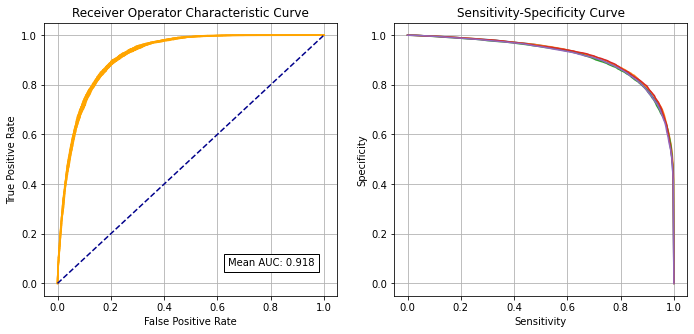

In [14]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for k in range(5):
    ax1.plot(fpr_kfold[k], tpr_kfold[k], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for k in range(5):
    ax2.plot(sensitivity_kfold[k], specificity_kfold[k])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over point on sensitivity-specificity curve

Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients *not* receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [15]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [16]:
intersections = []
for k in range(5):
    sens = np.array(sensitivity_kfold[k])
    spec = np.array(specificity_kfold[k])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.8393
SD intersection: 0.0027


### Collate and save results 

In [17]:
hospital_results = []
kfold_results = []
observed_results = []
prob_results = []
predicted_results = []

for k in range(5):
    hospital_results.extend(list(test_data_kfold[k]['Stroke team']))
    kfold_results.extend(list(np.repeat(k, len(test_data_kfold[k]))))
    observed_results.extend(list(y_test_kfold[k]))
    prob_results.extend(list(y_pred_proba_kfold[k]))
    predicted_results.extend(list(y_pred_class_kfold[k]))    
    
model_predictions = pd.DataFrame()
model_predictions['hospital'] = hospital_results
model_predictions['observed'] = np.array(observed_results) * 1.0
model_predictions['prob'] = prob_results
model_predictions['predicted'] = predicted_results
model_predictions['k_fold'] = kfold_results
model_predictions['correct'] = (
                model_predictions['observed'] == model_predictions['predicted'])

# Save
filename = f'./predictions/02_{model_text}_predictions.csv'
model_predictions.to_csv(filename, index=False)

# Save combined test set
combined_test_set = pd.concat(test_data_kfold, axis=0)
combined_test_set.reset_index(inplace=True); del combined_test_set['index']
combined_test_set.to_csv(f'./predictions/'
                         f'{notebook}_{model_text}_combined_test_features.csv', 
                         index=False)

## Compare predicted and actual thrombolysis rates

We compare the actual and predicted thrombolysis rates, taken from collating the five test sets (in k-fold validation all instances are in one, and only one, test set).

In [18]:
mean_results_by_hosp  = model_predictions.groupby('hospital').mean()

Get r-square of predicted thrombolysis rate.

In [19]:
x_comparision = np.array(mean_results_by_hosp['observed']).reshape(-1, 1)
y_comparision = np.array(mean_results_by_hosp['predicted']).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

print(f'R squared {r_square:0.3f}')

R squared 0.977


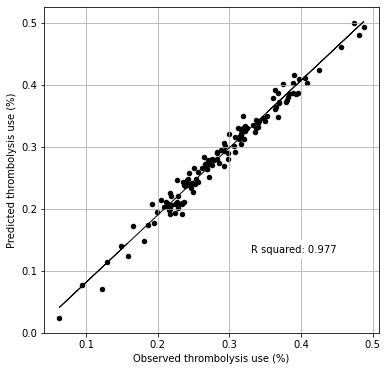

In [20]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_comparision,
            y_comparision, c='k', s=20)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'k', linewidth=1)
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, 
         bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()
plt.savefig(f'output/{notebook}_{model_text}_observed_predicted_rates.jpg', 
            dpi=300)
plt.show()

## Feature Importances

Get XGBoost feature importances (average across k-fold results)

In [21]:
# Feature names
feature_names = X_test_kfold[0].columns.values

# Get average feature importance from k-fold
importances = np.array(feature_importance_kfold).mean(axis = 0)

# Store in DataFrame
feature_importance_df = pd.DataFrame(data = importances, index=feature_names)
feature_importance_df.columns = ['importance']

# Sort by importance (weight)
feature_importance_df.sort_values(by='importance', 
                                  ascending=False, inplace=True)

# Save
feature_importance_df.to_csv(f'output/'
                             f'{notebook}_{model_text}_feature_importance.csv')

# Display top 25
feature_importance_df.head(25)

,importance
Infarction,0.338992
Use of AF anticoagulants,0.047162
Onset during sleep,0.033632
Precise onset time,0.029524
Stroke severity,0.013365
Prior disability level,0.012285
team_MHMYL4920B,0.011416
Arrival-to-scan time,0.011349
team_GKONI0110I,0.011299
team_QWKRA8499D,0.009606


Create a bar chart for the XGBoost feature importance values

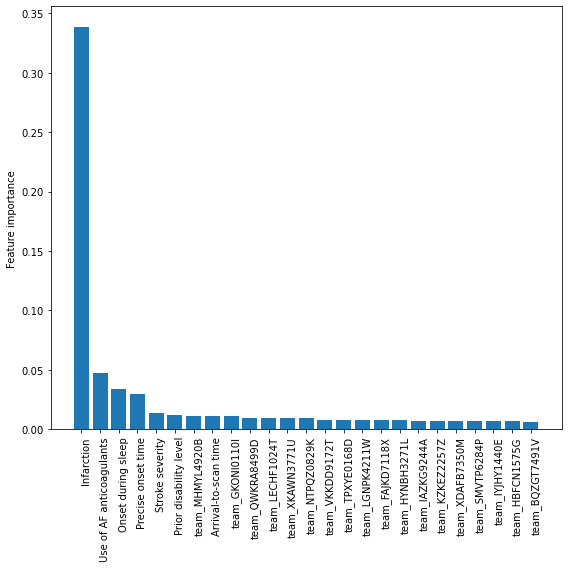

In [22]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = feature_importance_df.index.values[0:25]
pos = np.arange(len(labels))
val = feature_importance_df['importance'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature importance')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig(f'output/{notebook}_{model_text}_feature_weights_bar.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [23]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for k in range(5):
    
    # Get observed class and predicted probability
    observed = y_test_kfold[k]
    probability = y_pred_proba_kfold[k]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(probability, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = probability
    reliability['observed'] = observed
    classification = 1 * (probability > 0.5 )
    reliability['correct'] = observed == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = k

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [24]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.017739,0.022712,0.977288,0.480111
0.2,0.146044,0.174410,0.825590,0.082023
0.3,0.247906,0.270556,0.729444,0.055681
0.4,0.348492,0.370611,0.629389,0.045410
0.5,0.449804,0.443144,0.556856,0.042628
0.6,0.550810,0.546112,0.546112,0.041997
0.7,0.651586,0.642829,0.642829,0.049340
0.8,0.752894,0.736410,0.736410,0.064983
0.9,0.851912,0.827386,0.827386,0.089107


Plot results:

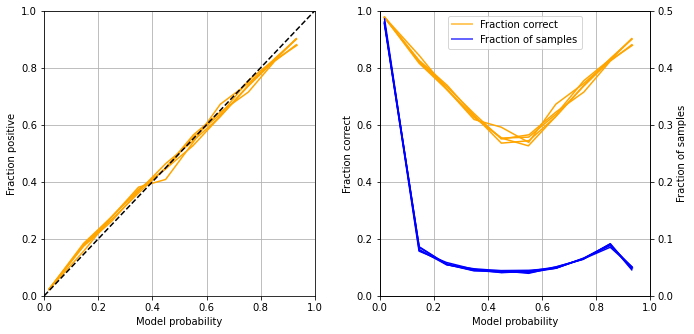

In [25]:
fig = plt.figure(figsize=(10,5))

# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax3 = ax2.twinx()  
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [26]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.700
Accuracy: 0.881


## Check for predicted thrombolysis in test set 

In [27]:
mask = combined_test_set['Infarction'] == 0
haemorrhagic_test = model_predictions['predicted'][mask]

In [28]:
count = len(haemorrhagic_test)
pos = haemorrhagic_test.sum()
print (f'{pos:.0f} predicted thrombolysis out of {count} haemorrhagic strokes')

0 predicted thrombolysis out of 13243 haemorrhagic strokes


## Learning curve

Examine the relationship between training data size and accuracy.

Plot learning curve

In [29]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data_kfold[0].shape[0]

# Get X and y for test (from first k-fold split)
X_test = X_test_kfold[0]
y_test = y_test_kfold[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get X and y for train (from first k-fold split)
        X_train = X_train_kfold[0]
        y_train = y_train_kfold[0]
       
        # Sample from training data
        X_train = X_train.sample(n=train_size)
        y_train = y_train.loc[X_train.index.values]

        # Define model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)

accuracy_kfold = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

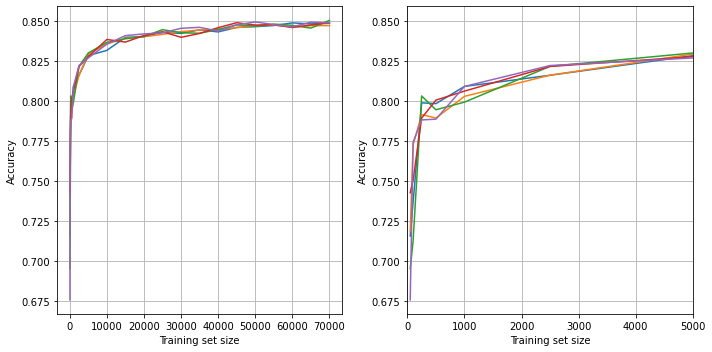

In [30]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for k in range(5):
    ax1.plot(results_training_size, accuracy_kfold[:, k])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy')
ax1.grid()

# Focus on first 5000
ax2 = fig.add_subplot(122)
for k in range(5):
    ax2.plot(results_training_size, accuracy_kfold[:, k])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)
ax2.grid()

plt.tight_layout()
plt.savefig(f'./output/{notebook}_{model_text}_learning_curve.jpg', dpi=300)
plt.show()